In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing  import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p1.csv')
df.head()

,date,Kwh,LaCR,LeCR,co2,LaF,LeF
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0


In [3]:
# 1.1 date 3개의 파생변수 
# month : 해당 시각의 월 정보
# day : 해당 시각의 일자 정보, 일요일-0, 월요일-1 ~ 토요일-6
# nsd : 해당 시각의 일자의 자정으로부터 소요된 총 분(minute)
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')

df['month'] = df['date'].dt.month

# dayofweek 0: 월요일 / 6: 일요일 6 + 1 % 7 
df['day'] = (df['date'].dt.dayofweek + 1) % 7

# nds 
df['nsd'] = df['date'].dt.minute + df['date'].dt.hour * 60 


In [4]:
df['ind11'] = (((df['month'] + df['day'] + df['nsd']) % 11 == 0) & ((df['month'] + df['day'] + df['nsd']) % 22 != 0)).astype(int)
df['ind22'] = ((df['month'] + df['day'] + df['nsd']) % 22 == 0).astype(int)

df.head()

,date,Kwh,LaCR,LeCR,co2,LaF,LeF,month,day,nsd,ind11,ind22
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,1,1,15,0,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1,1,30,0,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,1,1,45,0,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,1,1,60,0,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,1,1,75,1,0


In [5]:
# 파생변수명(Kwh8) : Kwh컬럼의 값이 4.1 초과일 경우 1 그 외 0 
df['Kwh8'] = df['Kwh'].map(lambda x : 1 if x > 4.1 else 0)
print(df['Kwh8'].value_counts()) 

Kwh8
1    18815
0    16225
Name: count, dtype: int64


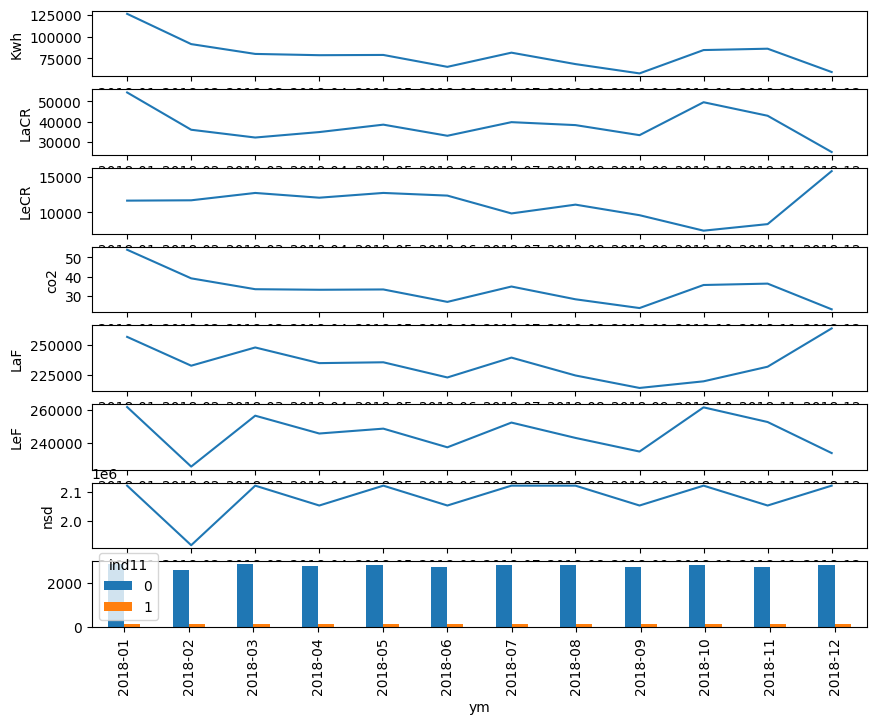

In [6]:
plot_df = df.copy()
plot_df['ym'] = plot_df['date'].dt.strftime('%Y-%m')
plot_cols = plot_df.drop(columns = ['date','month','day']).columns

plot_df = plot_df[plot_cols]
plot_df

fig, axes = plt.subplots(8, 1 , figsize = (10, 8))

for i, col in zip(axes.flatten() , plot_df.columns) : 
    if col not in ['ind11', 'ind22','Kwh8'] : 
        target = plot_df.groupby('ym')[col].sum().reset_index() 
        sns.lineplot(data = target, x = 'ym', y = col, ax = i)
    else : 
        target = plot_df.groupby(['ym', col]).size().unstack(fill_value = 0).reset_index()
        target.plot( x = 'ym' , kind = 'bar' , stacked = False, ax = i)
        
        

plt.show()

##### Kwh8를 종속 변수로 하여(Kwh제거) 분류 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용하라. confusionmatrix를 해석
- 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것, ind22칼럼의 값이 1인 데이터만 테스트에 사용할 것
- 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

c_df = df.drop(columns = ['date' , 'month','day','Kwh']) 

train_set = c_df[c_df['ind11'] == 1] 
x_train = train_set.drop(columns = 'Kwh8', axis = 1)
y_train = train_set['Kwh8']

test_set = c_df[c_df['ind22'] == 1]
x_test = test_set.drop(columns = 'Kwh8', axis = 1)
y_test = test_set['Kwh8'] 

#### Random Forest, SVC - GridSearch & Confusion Matrix 

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


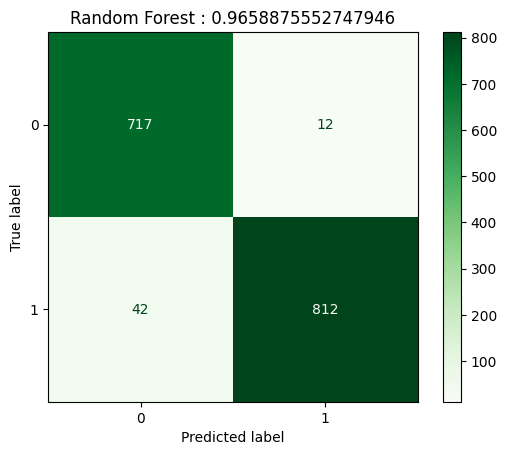

{'C': 1, 'kernel': 'linear'}


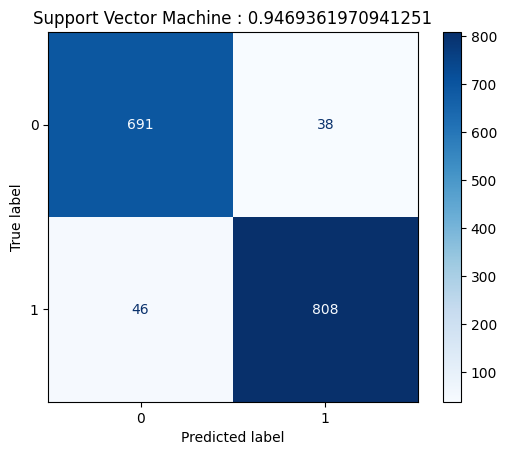

In [8]:

def eval_model(name, model, x_train, y_train, x_test, y_test): 
    if name == 'RF' : 
        params = {
            'n_estimators' : [1,10,100] , 
            'min_samples_split' : [2,3,4] , 
            'min_samples_leaf' :[1, 2]            
        }

        rf_grid = GridSearchCV(model, param_grid = params, cv = 5, scoring = 'accuracy') 
        rf_grid.fit(x_train, y_train)
        print(rf_grid.best_params_)
        
        #best model 
        best_model = rf_grid.best_estimator_ 
        best_pred = best_model.predict(x_test)
        score = accuracy_score(y_test, best_pred) 
        
        cm = confusion_matrix(y_test, best_pred)
        dis = ConfusionMatrixDisplay(confusion_matrix = cm)
        dis.plot(cmap=plt.cm.Greens)
        plt.title(f'Random Forest : {score}')
        plt.show()


    elif name == 'SVC' : 
        svc_params = {
            'C': [0.1,1,1.5, 2.0] ,
            'kernel': ["rbf","linear"]
        }

        scv_grid = GridSearchCV(model, svc_params, cv= 5, scoring = 'accuracy') 
        scv_grid.fit(x_train, y_train)
        print(scv_grid.best_params_)
        
        best_model = scv_grid.best_estimator_
        best_pred  = best_model.predict(x_test)
        
        score = accuracy_score(y_test, best_pred )

        cm = confusion_matrix(y_test, best_pred ) 
        dis = ConfusionMatrixDisplay(confusion_matrix = cm)
        dis.plot(cmap=plt.cm.Blues)
        plt.title(f'Support Vector Machine : {score}') 
        plt.show()

    return score, best_model


res = []
for name , model in [['RF', RandomForestClassifier()] , ['SVC' , SVC()]] :  
    score, best_model = eval_model(name, model , x_train, y_train, x_test, y_test)
    res.append([name, score, best_model]) 

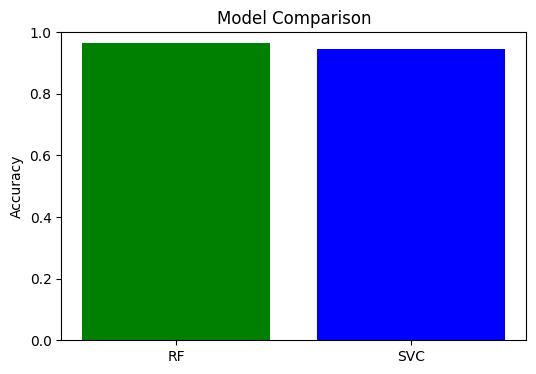

In [9]:
# 정확도 비교 그래프
model_names = [r[0] for r in res]
scores = [r[1] for r in res]

plt.figure(figsize=(6, 4))
plt.bar(model_names, scores, color=['green', 'blue'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()    
    

In [12]:
# 1-6 Kwh를 종속 변수로 하여(Kwh8 제거) 회귀 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용
l_df = df.drop(columns = ['date' , 'month','day','Kwh8']) 

train_set = l_df[l_df['ind11'] == 1] 
x_train = train_set.drop(columns = 'Kwh', axis = 1)
y_train = train_set['Kwh']

test_set = l_df[l_df['ind22'] == 1]
x_test = test_set.drop(columns = 'Kwh', axis = 1)
y_test = test_set['Kwh'] 


In [10]:

def linear_model_eval(name, model, x_train, y_train, x_test, y_test) : 
    pipeline = Pipeline([('scaler', StandardScaler()) , (name, model)]) 
    if name == 'SVR' : 
        param_grid = {
            f'{model_step_name}__C': [1, 10],
            f'{model_step_name}__kernel': ['linear', 'rbf'],
            f'{model_step_name}__tol': [0.001, 0.01]
        } 

        grid = GridSearchCV(model, param_grid, cv = 3, scoring = 'neg_mean_squared_error')
        grid.fit(x_train, y_train)

        best_model = grid.best_estimator_
        best_pred  = best_model.predict(x_test)

        # MSE 
        score = np.sqrt(mean_squared_error(y_test, best_pred)) 

    elif name == 'RF' : 


    return score, best_model  

for name, model in [['SVR', SVR()] , ['RF', RandomForestRegressor()]] : 
    score, best_model = linear_model_eval(name, model , x_train, y_train, x_test, y_test)
    res.append([name, score, best_model]) 
    

,date,Kwh,LaCR,LeCR,co2,LaF,LeF,month,day,nsd,ind11,ind22,Kwh8
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,1,1,15,0,0,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1,1,30,0,0,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,1,1,45,0,0,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,1,1,60,0,0,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,1,1,75,1,0,0
